## Lending Club loan analysis
This notebook looks at data from the Lending Club database. Obtained from Kaggle: (add URL)
* **Section 1: Exploratory analyses** is done to look at general features such as *average loan*, *interest rate* and *intallments* over time, *loan purposes* and *amounts* and *status* of loans. This is done in **SQL** and output files of the SQL query results are used here.
* **Section 2: Only good and bad loans will be examined** (based on information for loan status from above. 
Good and bad loans will be *stratified* by loan grade, US states the loans come from, loan amount, employment length, income, home ownership and installment. This is to examine if there are trends between type of loan and these features.
* **Section 3: Data cleaning:** columns will majority of missing values are dropped. If only a small percentage are missing, average values are used in place, where appropriate. Then, a *heatmap* is used to look at correlation between all remaining features.
* **ML model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn import cross
# from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

import folium as folium
import os
import seaborn as sns

In [2]:
import sklearn
print(sklearn.__version__)

0.20.2


### Section 1: Exploratory analyses

In [3]:
total= pd.read_csv("output/tot.csv")
tot = total["total records"][0]
print("The total number of records in the database is: {}.".format(tot))

The total number of records in the database is: 887383.


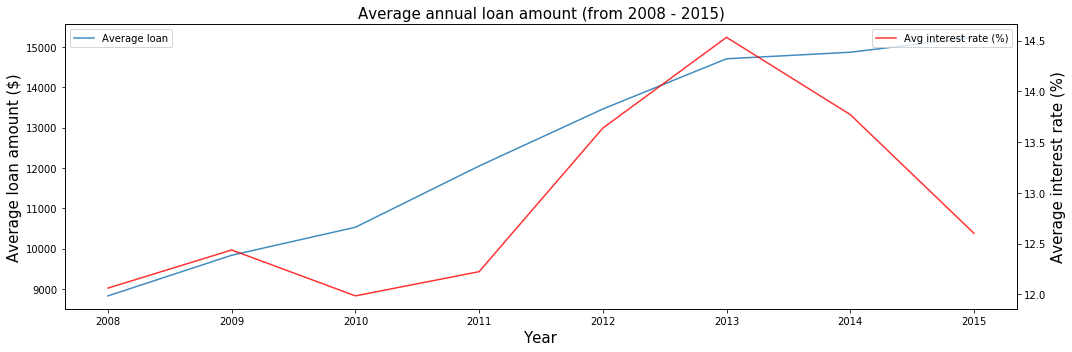

In [4]:
#average loan.
loan_month = pd.read_csv("output/avg-loan.csv")
xmonth = loan_month["loan_year"]
yavg_loan = loan_month["average_loan"]
month_cat = np.arange(len(xmonth))

#average interest.
int_month = pd.read_csv("output/avg-interest.csv")
yavg_int = int_month["interest_rate"]
month_cat = np.arange(len(xmonth))

#plot figure
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)

#figure for avg loan.
ax1.set_xlabel("Year",fontsize=15)
ax1.set_ylabel("Average loan amount ($)",fontsize=15)
ax1.set_title("Average annual loan amount (from 2008 - 2015)",fontsize=15)
ax1.plot(xmonth, yavg_loan, alpha=0.85, label="Average loan")

# #figure for avg interest.
ax2 = ax1.twinx()
ax2.set_ylabel("Average interest rate (%)",fontsize=15)
ax2.plot(xmonth, yavg_int, alpha=0.8, 
         label="Avg interest rate (%)",
         color="red")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()

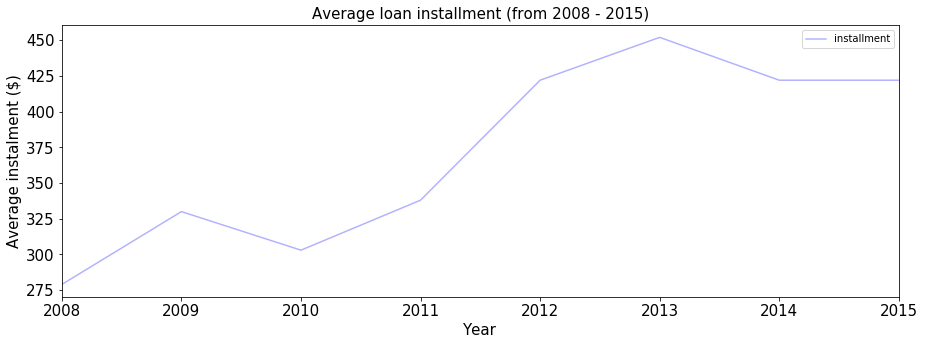

In [5]:
#average installment.
install = pd.read_csv("output/avg-installment.csv")
avg_instal = pd.DataFrame({"loan_year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
                           "installment": [279.0, 330.0, 303.0, 338.0, 422.0, 452.0, 422.0, 422.0]})
avg_instal.plot(kind="line", x="loan_year", y="installment", color="b", alpha=0.3, figsize=(15,5), fontsize=15)

plt.xlabel('Year', fontsize=15)
plt.ylabel('Average instalment ($)', fontsize=15)
plt.title('Average loan installment (from 2008 - 2015)', fontsize=15)
plt.show()

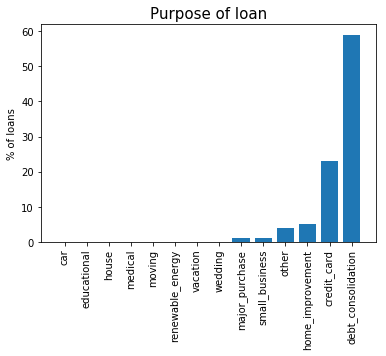

In [6]:
#purpose of loan
purpose = pd.read_csv("output/purpose.csv")
x_purpose = purpose["purpose"]
y_perct = purpose["Percentage"]
purpose_cat = np.arange(len(x_purpose))
plt.bar(x_purpose, y_perct)
plt.xticks(purpose_cat, x_purpose, rotation=90)
plt.ylabel("% of loans")
plt.title("Purpose of loan", fontsize=15)
plt.show()

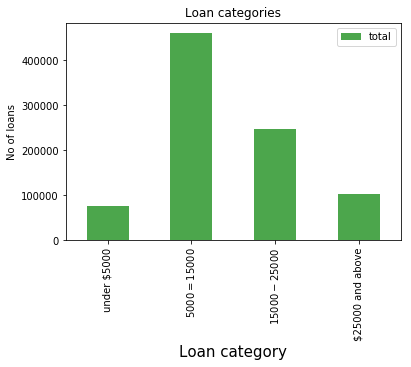

In [7]:
#loan amount categories
lf = pd.read_csv("output/loan-cat.csv")
lf = pd.DataFrame({"loan_amount": [1, 2, 3, 4], "total" : [75513, 460027, 248174, 103669]})
lf["loan_amount"] = lf["loan_amount"].replace({1: "under $5000", 2: "$5000 = $15000", 3: "$15000 - $25000", 4: "$25000 and above"})
lf.plot(kind="bar", x="loan_amount", y="total", color="g", alpha=0.7)

plt.xlabel('Loan category', fontsize=15)
plt.ylabel('No of loans')
plt.title('Loan categories')
plt.show()

In [8]:
# status of loans
loan_type = pd.read_csv("output/loan-status-overall.csv")
loan_type

,loan_status,No of loans
0,Does not meet the credit policy. Status:Charge...,761
1,Default,1219
2,Does not meet the credit policy. Status:Fully ...,1988
3,Late (16-30 days),2357
4,In Grace Period,6253
5,Issued,8460
6,Late (31-120 days),11591
7,Charged Off,45248
8,Fully Paid,207724
9,Current,601781


### Section 2: exploratory analyses stratified by good/bad loans.
Loans are categorized as follows:
1. Good loans (this will be made up of fully paid loans).
2. Bad loans (will consist of charged off loans. 
3. Remaining will not be taken into accoun.

In [9]:
#loan types we'll be looking at
loan_type = pd.read_csv("output/loan-status.csv")
print("The loans that will be examined in this notebook are as follows:")
loan_type

The loans that will be examined in this notebook are as follows:


,loan_status,number
0,Charged Off,45248
1,Fully Paid,207724


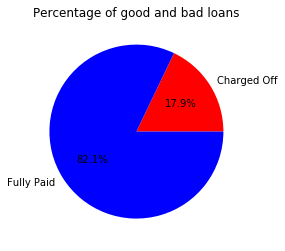

In [10]:
values = [45248, 207724]
colors = ["r", "b"]
labels = ["Charged Off", "Fully Paid"]
plt.pie(values, colors=colors, labels=labels, autopct="%0.1f%%")
plt.title("Percentage of good and bad loans")
plt.show()

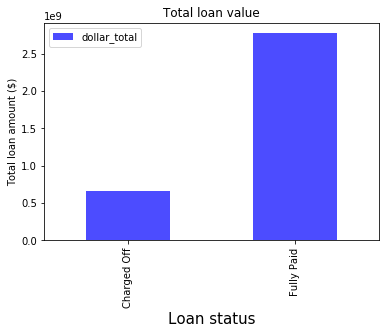

In [11]:
#Total dollar value of good and bad loans
loan_val = pd.read_csv("output/loans-total.csv")
loan_val.plot(kind="bar", x="loan_status", y="dollar_total", color="b", alpha=0.7)

plt.xlabel('Loan status', fontsize=15)
plt.ylabel('Total loan amount ($)')
plt.title('Total loan value')
plt.show()

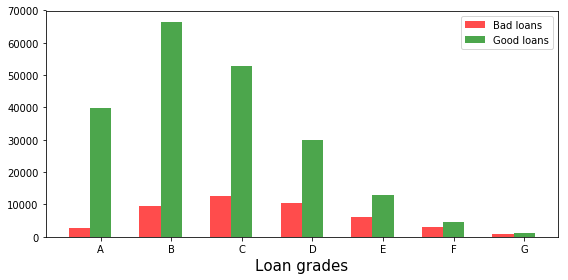

In [12]:
#good and bad loans by loan grade
lg = pd.read_csv("output/loans-grade.csv")
# loan_grade

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
xgrade = lg["grade"].drop_duplicates()
y_bad = lg[lg["loan_status"]== "Charged Off"]["loans number"]
y_good = lg[lg["loan_status"] == "Fully Paid"]["loans number"]

# Set position of bar on X axis
r1 = np.arange(len(xgrade))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Loan grades", fontsize=15)
plt.xticks([r + barWidth for r in range(len(xgrade))], ["A", "B", "C", "D", "E", "F", "G"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


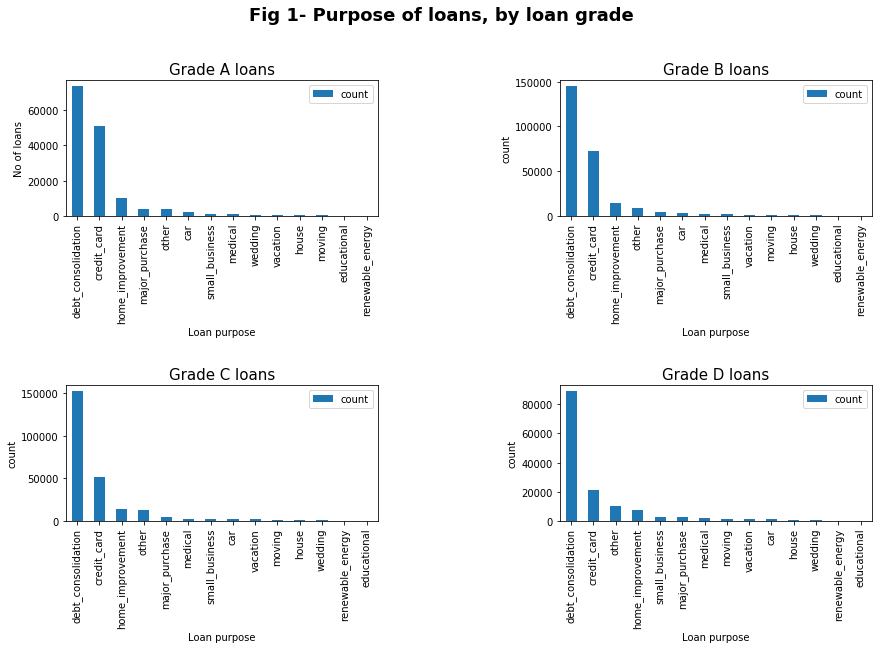

In [13]:
#Loan grade by purpose. From above, the majority of loans are Grades A- D so we will look at those.
#Setting up a figure to accomodate 4 grades given in the dataset. 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle("Fig 1- Purpose of loans, by loan grade", fontweight="bold", size=18)

#Grade A loans, by purpose.
gp_a = pd.read_csv("output/grade-a-purpose.csv")
gp_a.plot(kind="bar", ax=axes[0,0], x="purpose", y="count")
axes[0,0].set_title("Grade A loans", fontsize=15)
axes[0,0].set_xlabel("Loan purpose")
axes[0,0].set_ylabel("No of loans")

#Grade B loans, by purpose.
gp_b = pd.read_csv("output/grade-b-purpose.csv")
gp_b.plot(kind="bar", ax=axes[0,1], x="purpose", y="count")
axes[0,1].set_title("Grade B loans", fontsize=15)
axes[0,1].set_xlabel("Loan purpose")
axes[0,1].set_ylabel("count")

#Grade C loans, by purpose.
gp_c = pd.read_csv("output/grade-c-purpose.csv")
gp_c.plot(kind="bar", ax=axes[1,0], x="purpose", y="count")
axes[1,0].set_title("Grade C loans", fontsize=15)
axes[1,0].set_xlabel("Loan purpose")
axes[1,0].set_ylabel("count")

#Grade D loans, by purpose.
gp_d = pd.read_csv("output/grade-d-purpose.csv")
gp_d.plot(kind="bar", ax=axes[1,1], x="purpose", y="count")
axes[1,1].set_title("Grade D loans", fontsize=15)
axes[1,1].set_xlabel("Loan purpose")
axes[1,1].set_ylabel("count")

fig.tight_layout(pad=7, w_pad=12, h_pad=3)
fig.show()

In [14]:
#good loans by state
good_loans_state = pd.read_csv("output/good-loans-state.csv")

#Vol of loans by state.
#load map shape (US states)
state_geo = os.path.join("data", "us-states.json")

#load loan data for each state
df = os.path.join("output", "good-loans-state.csv")
good_loans = pd.read_csv(df)

#initialize map
m = folium.Map(location=[37, -102], zoom_start=4)

#set parameters for map, add color.
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=good_loans,
    columns=["addr_state", "loans_vol"],
    key_on="feature.id",
    fill_color="BuGn",
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name="No of good loans"
).add_to(m)
folium.LayerControl().add_to(m)
m

# # Save to html
# m.save("#good_loans_map.html")

In [15]:
#bad loans by state
bad_loans_state = pd.read_csv("output/bad-loans-state.csv")

#Vol of loans by state.
#load map shape (US states)
state_geo = os.path.join("data", "us-states.json")

#load loan data for each state
dl = os.path.join("output", "bad-loans-state.csv")
bad_loans = pd.read_csv(dl)

#initialize map
m = folium.Map(location=[37, -102], zoom_start=4)

#set parameters for map, add color.
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=bad_loans,
    columns=['addr_state', 'loans_vol'],
    key_on='feature.id',
    fill_color='RdPu',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='No of bad loans'
).add_to(m)
folium.LayerControl().add_to(m)
m

# # # Save to html
# # m.save("#bad_loans_map.html")

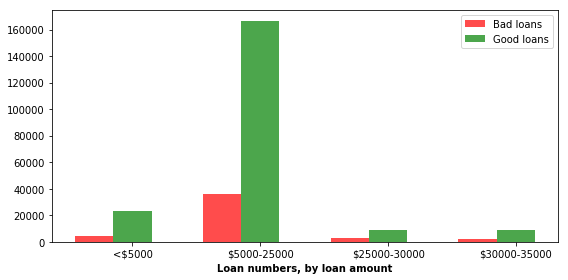

In [16]:
#loan amount by loan status
ls = pd.read_csv("output/loan-status-amount.csv")
ls = ls.reindex(index = [3, 2, 0, 1, 7, 6, 4, 5])

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
x_grade = ls["loans"].drop_duplicates()
y_bad = ls[ls["loan_status"] == "Charged Off"]["total"]
y_good = ls[ls["loan_status"] == "Fully Paid"]["total"]

# Set position of bar on X axis
r1 = np.arange(len(x_grade))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Loan numbers, by loan amount", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_grade))], ["<$5000", "$5000-25000", "$25000-30000", "$30000-35000"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

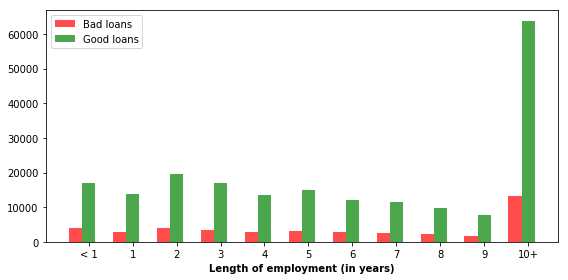

In [17]:
#employment length by loan type
el = pd.read_csv("output/employment-loan.csv")
el = el.reindex(index = [10, 0, 2, 3, 4, 5, 6, 7, 8, 9, 1, 21, 11, 13, 14, 15, 16, 17, 18, 19, 20, 12])

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
x_length = el["emp_length"].drop_duplicates()
y_bad = el[el["loan_status"] == "Charged Off"]["number"]
y_good = el[el["loan_status"] == "Fully Paid"]["number"]

# Set position of bar on X axis
r1 = np.arange(len(x_length))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7,width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Length of employment (in years)", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_length))], ["< 1", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

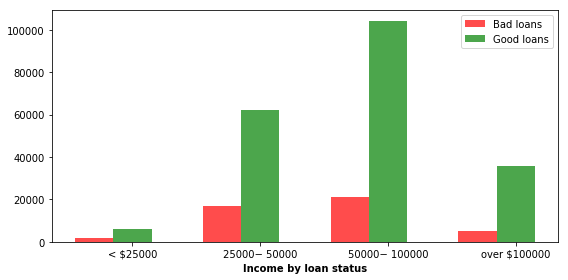

In [18]:
#income by loan type
li = pd.read_csv("output/income-loan.csv")
li = li.reindex(index = [2, 0, 1, 3, 6, 4, 5, 7])

#set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8,4))

#set height of bar
x_length = li["income"].drop_duplicates()
y_bad = li[li["loan_status"] == "Charged Off"]["total"]
y_good = li[li["loan_status"] == "Fully Paid"]["total"]

#set position of bar on X asia
r1 = np.arange(len(x_length))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Income by loan status", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_length))], ["< $25000", "25000− 50000", "50000− 100000", "over $100000"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

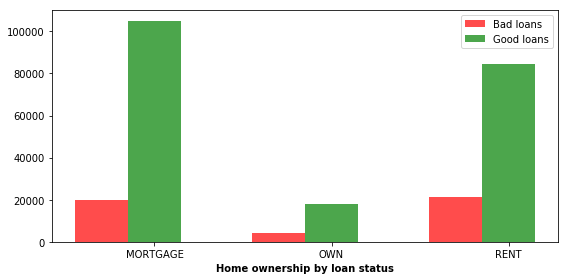

In [19]:
#home ownership by loan type
lh = pd.read_csv("output/home-loan.csv")

# set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(8, 4))

# set height of bar
x_length = lh["home_ownership"].drop_duplicates()
y_bad = lh[lh["loan_status"] == "Charged Off"]["total"]
y_good = lh[lh["loan_status"] == "Fully Paid"]["total"]

# Set position of bar on X axis
r1 = np.arange(len(x_length))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, y_bad, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, y_good, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Home ownership by loan status", fontweight="bold")
plt.xticks([r + barWidth for r in range(len(x_length))], ["MORTGAGE", "OWN", "RENT"])
 
# Create legend & Show graphic
plt.legend()
fig.tight_layout()
plt.show()

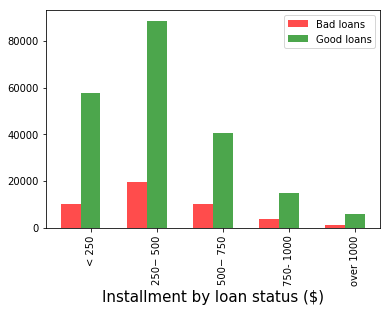

In [20]:
#installment by loan type
inst = pd.read_csv("output/loan-installment.csv")
inst = inst.reindex( index = [3, 0, 1, 2, 4, 8, 5, 6, 7, 9])
inst

#set width of bar
barWidth = 0.3
fig = plt.figure(figsize=(6, 4))

#set height of bar
bars1 = [10155, 19631, 10163, 3896, 1403]
bars2 = [57603, 88509, 40555, 15140, 5917]

# #set position of bar on X asia
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color="r", alpha=0.7, width=barWidth, label="Bad loans")
plt.bar(r2, bars2, color="g", alpha=0.7, width=barWidth, label="Good loans")
 
# Add xticks on the middle of the group bars
plt.xlabel("Installment by loan status ($)", fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], ["< 250", "250− 500", "500− 750", "750- 1000", "over 1000"], rotation=90)
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Section 3: Data Cleaning

In [21]:
df = pd.read_csv("data/loan.csv", low_memory=False)
half_count = len(df) / 2

#Drop thos with more than 50% missing values.
df = df.dropna(thresh=half_count, axis=1)

#Drop the following column which is not useful
df = df.drop(["url"], axis=1)

#Now, look at first 5 rows of dataset.
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaN,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,67.79,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [22]:
#look at shape of data
df.shape

(887379, 52)

In [23]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [24]:
#Columns will be divided into 3 categories to make examining data clearer. 
#First batch: look at the first 20 columns
df.iloc[:, :19]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose
0,1077501,1296599,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,n,credit_card
1,1077430,1314167,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,n,car
2,1077175,1313524,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,n,small_business
3,1076863,1277178,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,n,other
4,1075358,1311748,3000.0,3000.0,3000.000000,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-2011,Current,n,other
5,1075269,1311441,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.00,Source Verified,Dec-2011,Fully Paid,n,wedding
6,1069639,1304742,7000.0,7000.0,7000.000000,60 months,15.96,170.08,C,C5,Southern Star Photography,8 years,RENT,47004.00,Not Verified,Dec-2011,Current,n,debt_consolidation
7,1072053,1288686,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,RENT,48000.00,Source Verified,Dec-2011,Fully Paid,n,car
8,1071795,1306957,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.00,Source Verified,Dec-2011,Charged Off,n,small_business
9,1071570,1306721,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,B5,Starbucks,< 1 year,RENT,15000.00,Verified,Dec-2011,Charged Off,n,other


In [25]:
#from the above, we can remove the following columns from teh dataframe.
drop_list = ['id','member_id','funded_amnt','funded_amnt_inv',
             'int_rate','sub_grade','emp_title','issue_d']
df = df.drop(drop_list,axis=1)

In [26]:
#Next, look at column 20 to 40.
df.iloc[50:60, 19:]

,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50,0.0,11845.0,63.7,28.0,f,0.0,0.0,16177.770000,16177.77,13556.45,...,483.38,NaN,Mar-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
51,0.0,26088.0,62.0,27.0,f,0.0,0.0,29695.622676,29405.63,25600.00,...,838.27,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
52,0.0,12168.0,92.9,12.0,f,0.0,0.0,8205.473816,8205.47,7000.00,...,240.27,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
53,0.0,15793.0,90.8,11.0,f,0.0,0.0,3521.950000,3521.95,1903.66,...,421.65,NaN,Dec-2012,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
54,0.0,12143.0,52.1,12.0,f,0.0,0.0,13748.213110,13748.21,12000.00,...,964.73,NaN,Jul-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
55,0.0,19448.0,97.6,14.0,f,0.0,0.0,18319.140000,18297.35,8990.81,...,555.33,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
56,0.0,27884.0,75.1,21.0,f,0.0,0.0,20876.100000,20810.87,16000.00,...,9931.02,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
57,0.0,12874.0,72.7,10.0,f,0.0,0.0,11474.760000,11474.76,10000.00,...,5803.94,NaN,Mar-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
58,0.0,10160.0,59.1,24.0,f,0.0,0.0,10575.940000,10575.94,10000.00,...,8627.74,NaN,Sep-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
59,0.0,6021.0,91.2,8.0,f,0.0,0.0,9079.334843,9079.33,7100.00,...,262.78,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [27]:
#Based on the above, the following columns will be removed.
drop_cols = [ 'zip_code','out_prncp','out_prncp_inv',
             'total_pymnt','total_pymnt_inv', 'delinq_2yrs']
df = df.drop(drop_cols, axis=1)

drop_cols2 = ['total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt']
df = df.drop(drop_cols2, axis=1)
df

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,...,initial_list_status,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.00,Verified,Fully Paid,n,...,f,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.00,Source Verified,Charged Off,n,...,f,NaN,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.00,Not Verified,Fully Paid,n,...,f,NaN,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.00,Source Verified,Fully Paid,n,...,f,NaN,Jan-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,3000.0,60 months,67.79,B,1 year,RENT,80000.00,Source Verified,Current,n,...,f,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
5,5000.0,36 months,156.46,A,3 years,RENT,36000.00,Source Verified,Fully Paid,n,...,f,NaN,Sep-2015,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
6,7000.0,60 months,170.08,C,8 years,RENT,47004.00,Not Verified,Current,n,...,f,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
7,3000.0,36 months,109.43,E,9 years,RENT,48000.00,Source Verified,Fully Paid,n,...,f,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
8,5600.0,60 months,152.39,F,4 years,OWN,40000.00,Source Verified,Charged Off,n,...,f,NaN,Aug-2012,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
9,5375.0,60 months,121.45,B,< 1 year,RENT,15000.00,Verified,Charged Off,n,...,f,NaN,Mar-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [28]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

In [29]:
#After looking through the above, drop all columns with NaN values or info from future/not relevant.
drop_cols3 = ['next_pymnt_d', 'collections_12_mths_ex_med', 'policy_code', 'application_type',
             'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
df = df.drop(drop_cols3, axis=1)

In [30]:
df.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,...,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,n,...,27.65,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,Jan-2016
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,...,1.00,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,Sep-2013
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,...,8.72,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,Jan-2016
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,n,...,20.00,Feb-1996,1.0,10.0,0.0,5598.0,21.0,37.0,f,Jan-2015
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,n,...,17.94,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,Jan-2016


In [31]:
#look at unique instance of pymnt_plan column
df["pymnt_plan"].unique().tolist()

['n', 'y']

In [32]:
#We can see there are 2 unique instances.
print("No of instances of y in pyment_plan: {}".format((df["pymnt_plan"]== "y").sum()))
print("No of instances of n in pyment_plan: {}".format((df["pymnt_plan"]== "n").sum()))

No of instances of y in pyment_plan: 10
No of instances of n in pyment_plan: 887369


In [33]:
#Give the above, we see that there are too few instances of y compared to n to make meaningful inferences.
df = df.drop("pymnt_plan", axis=1)
df.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,...,27.65,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,Jan-2016
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,...,1.00,Apr-1999,5.0,3.0,0.0,1687.0,9.4,4.0,f,Sep-2013
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,...,8.72,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,Jan-2016
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,...,20.00,Feb-1996,1.0,10.0,0.0,5598.0,21.0,37.0,f,Jan-2015
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other,...,17.94,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,Jan-2016


In [34]:
#look at unique instance of initial_list_status column
df["initial_list_status"].unique().tolist()

['f', 'w']

In [35]:
#We can see there are 2 unique instances. This column will be kept.
print("No of instances of f in the initial_list_status column: {}".format((df["initial_list_status"]== "f").sum()))
print("No of instances of w in initial_list_status column: {}".format((df["initial_list_status"]== "w").sum()))

No of instances of f in the initial_list_status column: 456848
No of instances of w in initial_list_status column: 430531


In [36]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'last_credit_pull_d'],
      dtype='object')

In [37]:
#After looking through the above, drop the following columns- no
drop_cols4 = ["title", "inq_last_6mths", "initial_list_status"]
df = df.drop(drop_cols4, axis=1)

In [38]:
# #save this work.
df.to_csv("data/updated_loan_data.csv", index=False)

### Machine Learning Prep

In [39]:
#preparing data for machine learning
#updated loan file from above.
updated_loans = pd.read_csv("data/updated_loan_data.csv")
print(updated_loans.shape)
updated_loans.head()

(887379, 19)


,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,27.65,Jan-1985,3.0,0.0,13648.0,83.7,9.0,Jan-2016
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,1.00,Apr-1999,3.0,0.0,1687.0,9.4,4.0,Sep-2013
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,8.72,Nov-2001,2.0,0.0,2956.0,98.5,10.0,Jan-2016
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,20.00,Feb-1996,10.0,0.0,5598.0,21.0,37.0,Jan-2015
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other,OR,17.94,Jan-1996,15.0,0.0,27783.0,53.9,38.0,Jan-2016


In [40]:
updated_loans.columns

Index(['loan_amnt', 'term', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'last_credit_pull_d'],
      dtype='object')

#### Let's look at the target value first- "Loan status"

In [41]:
#Target column: loan_status.
updated_loans["loan_status"].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [42]:
#convert loan status to binary measures.
updated_loans = updated_loans[(updated_loans["loan_status"] == "Fully Paid") | (updated_loans["loan_status"] == "Charged Off")]
updated_loans["loan_status"].unique().tolist()
# mapping_dict = {"loan_status": {"Fully Paid": 1, "Charged Off": 0}}
# df = df.replace(mapping_dict)

['Fully Paid', 'Charged Off']

In [43]:
# #examine pie chart of % good and bad loans.
# values = [45248, 207723]
# colors = ["r", "b"]
# labels = ["Charged Off", "Fully Paid"]
# plt.pie(values, colors=colors, labels=labels, autopct="%0.1f%%")
# plt.title("Percentage of good and bad loans")
# plt.show()

### Missing values

In [44]:
#missing values
null_values = updated_loans.isnull().sum()
null_values

loan_amnt                 0
term                      0
installment               0
grade                     0
emp_length             9897
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
addr_state                0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              199
total_acc                 0
last_credit_pull_d       21
dtype: int64

In [45]:
updated_loans.dtypes

loan_amnt              float64
term                    object
installment            float64
grade                   object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
loan_status             object
purpose                 object
addr_state              object
dti                    float64
earliest_cr_line        object
open_acc               float64
pub_rec                float64
revol_bal              float64
revol_util             float64
total_acc              float64
last_credit_pull_d      object
dtype: object

In [46]:
#drop rows with missing values
updated_loans = updated_loans.dropna()

Let's look at the numerical features first- open_acc, pub_rec, revol_util, total_acc, annual_inc. For each column, find the current median value.

In [47]:
median_open_acc = updated_loans["open_acc"].median()
median_pub_rec = updated_loans["pub_rec"].median()
median_revol_util = updated_loans["revol_util"].median()
median_total_acc = updated_loans["total_acc"].median()
median_annual_inc = updated_loans["annual_inc"].median()

print("Median value for open_acc is: {}".format(median_open_acc))
print("Median value for pub_rec is: {}".format(median_pub_rec))
print("Median value for revol_util is: {}".format(median_revol_util))
print("Median value for total_acc is: {}".format(median_total_acc))
print("Median value for annua_inc is: {}".format(median_annual_inc))

Median value for open_acc is: 10.0
Median value for pub_rec is: 0.0
Median value for revol_util is: 55.9
Median value for total_acc is: 23.0
Median value for annua_inc is: 63000.0


In [48]:
#Use the median value from above to fill in the rows with missing values, for the respective features. 
#We will drop the pub_rec column.

In [49]:
#Drop pub_rec
updated_loans = updated_loans.drop("pub_rec", axis=1)

In [50]:
#use fillna to add median value to the empty rows for the respective columns.
updated_loans["open_acc"].fillna(median_open_acc, inplace=True)
updated_loans["revol_util"].fillna(median_revol_util, inplace=True)
updated_loans["total_acc"].fillna(median_total_acc, inplace=True)
updated_loans.isnull().sum()

loan_amnt              0
term                   0
installment            0
grade                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
loan_status            0
purpose                0
addr_state             0
dti                    0
earliest_cr_line       0
open_acc               0
revol_bal              0
revol_util             0
total_acc              0
last_credit_pull_d     0
dtype: int64

### Categorical variables

Now, let's look at the categorical variables. 

In [51]:
#By looking at a specific row, we can see how categorical variables are formatted
obj_col = updated_loans.select_dtypes(include=["object"])
print(obj_col.iloc[5])

term                         36 months
grade                                E
emp_length                     9 years
home_ownership                    RENT
verification_status    Source Verified
loan_status                 Fully Paid
purpose                            car
addr_state                          CA
earliest_cr_line              Jan-2007
last_credit_pull_d            Dec-2014
Name: 7, dtype: object


In [52]:
#We'll remove the date values columns as these are not useful. These are earliest_cr_line and last_credit_pull_d.
drop_cols5 = ["earliest_cr_line", "last_credit_pull_d"]
updated_loans = updated_loans.drop(drop_cols5, axis=1)

In [53]:
#N, we'll look at unique values of the remaining categorical variables.
term_unique = updated_loans["term"].unique()
grade_unique = updated_loans["grade"].unique()
emp_length_unique = updated_loans["emp_length"].unique()
home_own_unique = updated_loans["home_ownership"].unique()
ver_status_unique = updated_loans["verification_status"].unique()
purpose_unique = updated_loans["purpose"].unique()
add_state_unique = updated_loans["addr_state"].unique()

print("The unique instances of loan term are: {}".format(term_unique))
print("The unique instances of loan term are: {}".format(grade_unique))
print("The unique instances of loan term are: {}".format(emp_length_unique))
print("The unique instances of loan term are: {}".format(home_own_unique))
print("The unique instances of loan term are: {}".format(ver_status_unique))
print("The unique instances of loan term are: {}".format(purpose_unique))
print("The unique instances of loan term are: {}".format(add_state_unique))

The unique instances of loan term are: [' 36 months' ' 60 months']
The unique instances of loan term are: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
The unique instances of loan term are: ['10+ years' '< 1 year' '3 years' '9 years' '4 years' '5 years' '1 year'
 '6 years' '2 years' '7 years' '8 years']
The unique instances of loan term are: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
The unique instances of loan term are: ['Verified' 'Source Verified' 'Not Verified']
The unique instances of loan term are: ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
The unique instances of loan term are: ['AZ' 'GA' 'IL' 'CA' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA' 'MN' 'NJ'
 'OR' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'NV' 'AK' 'CO' 'MD'
 'WV' 'VT' 'MI' 'DC' 'SD' 'NC' 'AR' 'NM' 'KS' 'HI' 'OK' 'MT' 'WY' 'NH'
 'DE' 'MS' 'TN' 'IA' 'NE' 'ID' 'IN' 'ME' 'ND']


In [54]:
#convert categorical variables to integers using mapping dictionary.
mapping_dict = {
    "term": {
        " 36 months": 1,
        " 60 months": 0
    },
    "grade": {
        "A": 1,
        "B": 2,
        "C": 3,
        "D": 4,
        "E": 5,
        "F": 6,
        "G": 7
    },
    "loan_status": {
        "Fully Paid": 1, 
        "Charged Off": 0
    }, 
    "emp_length": {
        "10+ years": 11,
        "9 years": 10,
        "8 years": 9,
        "7 years": 8,
        "6 years": 7,
        "5 years": 6,
        "4 years": 5,
        "3 years": 4,
        "2 years": 3,
        "1 year": 2,
        "< 1 year": 1,
        "nan": 0
    },
    "home_ownership": {
        "RENT": 1,
        "OWN": 2,
        "MORTGAGE": 3,
        "OTHER": 4,
        "NONE": 5,
        "ANY": 6
    },
    "verification_status": {
        "Verified": 1,
        "Source Verified": 2,
        "Not Verified": 3
    },
    "purpose": {
        "credit_card": 1,
        "car": 2,
        "small_business": 3,
        "other": 4,
        "wedding": 5,
        "debt_consolidation": 6,
        "home_improvement": 7,
        "major_purchase": 8,
        "medical": 9,
        "moving": 10,
        "vacation": 11,
        "house": 12,
        "renewable_energy": 13,
        "educational": 14
    },
    "addr_state": {
        'AZ': 1,'GA': 2, 'IL': 3, 'CA': 4, 'OR': 5, 'NC': 6, 'TX': 7, 'VA': 8, 'MO': 9, 'CT': 10, 'UT': 11, 
        'FL': 12, 'NY': 13, 'PA': 14, 'MN': 15, 'NJ': 16, 'KY': 17, 'OH': 18, 'SC': 19, 'RI': 20, 'LA': 21,
        'MA': 22, 'WA': 23, 'WI': 24, 'AL': 25, 'CO': 26, 'KS': 27, 'NV': 28, 'AK': 29, 'MD': 30, 'WV': 31,
        'VT': 32, 'MI': 33, 'DC': 34, 'SD': 35, 'NH': 36, 'AR': 37, 'NM': 38, 'MT': 39, 'HI': 40, 'WY': 41, 
        'OK': 42, 'DE': 43, 'MS': 44, 'TN': 45, 'IA': 46, 'NE': 47, 'ID': 48, 'IN': 49, 'ME': 50, 'ND': 51}
}

updated_loans = updated_loans.replace(mapping_dict)
updated_loans[["term", "grade", "loan_status", "emp_length", "home_ownership", "verification_status", "purpose", "addr_state"]].head()

,term,grade,loan_status,emp_length,home_ownership,verification_status,purpose,addr_state
0,1,2,1,11,1,1,1,1
1,0,3,0,1,1,2,2,2
2,1,3,1,11,1,3,3,3
3,1,3,1,11,1,2,4,4
5,1,1,1,4,1,2,5,1


In [ ]:
updated_loans[["term", "grade", "loan_status", "emp_length", "home_ownership", "verification_status", "purpose", "addr_state"]].head()

In [55]:
updated_loans.to_csv("data/cleaned_loan_data.csv",index=False)

### Machine Learning Model

### K-Nearest-Neighbours Model

In [65]:
#open the cleaned data file.
cleaned_data = pd.read_csv("data/cleaned_loan_data.csv")
cleaned_data.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,revol_bal,revol_util,total_acc
0,5000.0,1,162.87,2,11,1,24000.0,1,1,1,1,27.65,3.0,13648.0,83.7,9.0
1,2500.0,0,59.83,3,1,1,30000.0,2,0,2,2,1.00,3.0,1687.0,9.4,4.0
2,2400.0,1,84.33,3,11,1,12252.0,3,1,3,3,8.72,2.0,2956.0,98.5,10.0
3,10000.0,1,339.31,3,11,1,49200.0,2,1,4,4,20.00,10.0,5598.0,21.0,37.0
4,5000.0,1,156.46,1,4,1,36000.0,2,1,5,1,11.20,9.0,7963.0,28.3,12.0


In [119]:
cleaned_data.shape

(242863, 16)

In [66]:
#define features and target variable for decision tree model.
#convert categorical variables into dummy variables.
X = cleaned_data.loc[:, cleaned_data.columns != "loan_status"]
y = cleaned_data.loc[:, "loan_status"]

In [67]:
print(X.shape)
print(y.shape)

(242863, 15)
(242863,)


In [69]:
#import the class
from sklearn.neighbors import KNeighborsClassifier

In [74]:
#instantiate the estimator
knn = KNeighborsClassifier(n_neighbors=1)

In [75]:
#fit the model
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [84]:
#make a prediction using a new observation. One made up for this.
obs = np.array( [8000, 1, 180, 3, 7, 2, 45000, 2, 1, 10, 11.3, 5, 6843, 35, 27])
obs = np.reshape(obs, (1, -1))
knn.predict(obs)

array([1])

In [89]:
#Make 2 more new obs.
add_obs = np.array([2600, 0, 190, 2, 4, 1, 27600, 3, 11, 5, 4, 6, 1847.3, 23, 12.0])
add_obs = np.reshape(add_obs, (1, -1))
knn.predict(add_obs)

array([1])

### KNN model with a diff value

In [104]:
#instantiate the estimator
knn = KNeighborsClassifier(n_neighbors=15)

In [105]:
#fit the model
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [106]:
#make a prediction using a new observation. One made up for this.
obs = np.array( [8000, 1, 180, 3, 7, 2, 45000, 2, 1, 10, 11.3, 5, 6843, 35, 27])
obs = np.reshape(obs, (1, -1))
knn.predict(obs)

array([1])

In [107]:
#Make 2 more new obs.
add_obs = np.array([2600, 0, 190, 2, 4, 1, 27600, 3, 11, 5, 4, 6, 1847.3, 23, 12.0])
add_obs = np.reshape(add_obs, (1, -1))
knn.predict(add_obs)

array([1])

### Logistic Regression model

In [108]:
#import the class
from sklearn.linear_model import LogisticRegression

In [109]:
#instantiatite the model
logreg = LogisticRegression()

In [111]:
#fit the model with data.
logreg.fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [115]:
#make predictions
logreg.predict(obs)

array([1])

In [116]:
logreg.predict(add_obs)

array([1])

### Predict response values for observations in X. Use all values in X (train and test).

#### Accuracy score for Logistic Regression model

In [123]:
# #store prediction responses
# y_pred = logreg.predict(X)

In [124]:
# #see how many predictions are made.
# len(y_pred)

242863

In [126]:
# #compute classification accuracy for the logreg model. Training accuracy
# from sklearn import metrics
# print(metrics.accuracy_score(y, y_pred))

0.8241683582925353


#### Accuracy score for KNN

In [128]:
# knn = KNeighborsClassifier(n_neighbors=1)
# knn.fit(X,y)
# y_pred = knn.predict(X)
# knn_score1 = metrics.accuracy_score(y, y_pred)
# print(knn_score1)

1.0


### Accuracy score for KNN 15

In [129]:
# knn = KNeighborsClassifier(n_neighbors=15)
# knn.fit(X,y)
# y_pred = knn.predict(X)
# knn_score1 = metrics.accuracy_score(y, y_pred)
# print(knn_score1)

0.8252842137336688


#### logreg model accuracy

In [130]:
#open the cleaned data file.
cleaned_data = pd.read_csv("data/cleaned_loan_data.csv")
cleaned_data.head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,revol_bal,revol_util,total_acc
0,5000.0,1,162.87,2,11,1,24000.0,1,1,1,1,27.65,3.0,13648.0,83.7,9.0
1,2500.0,0,59.83,3,1,1,30000.0,2,0,2,2,1.00,3.0,1687.0,9.4,4.0
2,2400.0,1,84.33,3,11,1,12252.0,3,1,3,3,8.72,2.0,2956.0,98.5,10.0
3,10000.0,1,339.31,3,11,1,49200.0,2,1,4,4,20.00,10.0,5598.0,21.0,37.0
4,5000.0,1,156.46,1,4,1,36000.0,2,1,5,1,11.20,9.0,7963.0,28.3,12.0


In [131]:
#define features and target variable for decision tree model.
#convert categorical variables into dummy variables.
X = cleaned_data.loc[:, cleaned_data.columns != "loan_status"]
y = cleaned_data.loc[:, "loan_status"]

In [144]:
print(X.shape)
print(y.shape)

(242863, 15)
(242863,)


In [132]:
#logreg model
#separate dataset into training and testing datasets.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [145]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(194290, 15)
(48573, 15)
(194290,)
(48573,)


In [133]:
#instantiate logistic regression.
logreg = LogisticRegression()

In [134]:
#fit logistic regression model to the training set.
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [135]:
#to predict the test set results.
y_pred_class = logreg.predict(X_test)

In [136]:
y_pred_class

array([1, 1, 1, ..., 1, 1, 1])

In [137]:
#logistic regression model accuracy
from sklearn.metrics import accuracy_score
lm_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print("Accuracy score using Logistic Regression: %.2f%%" % (lm_accuracy * 100.0))

Accuracy score using Logistic Regression: 82.42%


In [138]:
#logistic regression confusion matrix
cm_log = metrics.confusion_matrix(y_test, y_pred_class)
print("Confusion matrix for Logistic Regression model:")
print(cm_log)

Confusion matrix for Logistic Regression model:
[[    6  8527]
 [   12 40028]]


In [139]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 40028
True Negatives: 6
False Positives: 8527
False Negatives: 12


In [140]:
sensitivity = TP / float(TP + FN)
print("Sensitivity: %.2f%%" % (sensitivity * 100))

Sensitivity: 99.97%


In [141]:
specificity= TN / float(TN + FP)
print("Specificity: %.2f%%" % (specificity * 100))

Specificity: 0.07%


In [142]:
fp = FP / float(TN + FP)
print("False Positive rate: %.2f%%" % (fp * 100))

False Positive rate: 99.93%


In [143]:
precision = TP / float(FP + TP)
print("Precision rate: %.2f%%" % (precision * 100))

Precision rate: 82.44%


### KNN=1 model

In [146]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn_score1 = metrics.accuracy_score(y_test, y_pred)
print(knn_score1)

0.7193090811767855


In [152]:
k_range = range(1, 30)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    knn_score_total = metrics.accuracy_score(y_test, y_pred)
    scores.append(knn_score_total)

Text(0, 0.5, 'Testing accuracy')

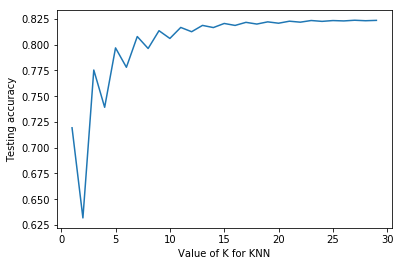

In [153]:
plt.plot(k_range, scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Testing accuracy")

### KNN=10 model

In [155]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn_score10 = metrics.accuracy_score(y_test, y_pred)
print(knn_score10)

0.8060033351862146


### Make predictions on out of sample data using best model (n=15)

In [157]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X, y)
print(knn.predict(obs))
print(knn.predict(add_obs))

[1]
[1]
